# Land Cover Classification
![](img/corine.png)

{octicon}`calendar` Apr, 2025

> [CORINE](https://land.copernicus.eu/en/products/corine-land-cover) (Coordination of Information on the Environment) Land Cover is a European program for developping a standardized methodology for producing continent-scale land cover maps. CORINE Land Cover (CLC) product offers a pan-European land cover and land use inventory with 44 thematic classes, ranging from broad forested areas to individual vineyards. The product is updated with new status and change layers every six years—with the most recent update made in 2018.

In this project [Google Earth Engine (GEE)](https://earthengine.google.com/) will be used to:
- Download Sentinel-2 satellite imagery of the last few years, clipped around an area of interest.
- Imagery of a time period (normally a year) will be combined to obtain a clean enough composite image.
- The image corresponding to 2018 will be used to train a classification model using the partitions of the land provided by the CORINE Land Cover 2018.
- This model will later be used to classify land cover of a more recent image (from 2024), defining over the raster file a band with the class of each pixel on the image, corresponding to the type of land.
- Finally, this file will be vectorized (i.e. turn contiguous pixels of the same class into polygons or points), and then exported as GeoJSON for storage and further analysis.

## Setup and Initialization

In [1]:
import json

import contextily as ctx
import ee  # Interface to Google Earth Engine
import geemap  # Provides tools for interactive map visualization using GEE
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import box

In [2]:
# Authenticate and initialize the Earth Engine session
ee.Authenticate()
ee.Initialize(project=project_key)

## Defining the Study Area
First, I download municipal boundaries of the province of Gipuzkoa (Spain) from https://b5m.gipuzkoa.eus/web5000/en/datasets/municipal-boundaries

In [3]:
municipalities = gpd.read_file("data/gipuzkoa_municipios.geojson")
municipalities

,IDNOMBRE,CODMUNI,HERCODI,MUNICIPIO,COMARCA,CODMUNIINE,CODIZFE,F_CARGA,geometry
0,1.0,001,30601,Abaltzisketa,Tolosaldea,20001,001,2025-03-30,"POLYGON ((-2.09997 43.01327, -2.11028 43.00989..."
1,2.0,002,30602,Aduna,Tolosaldea,20002,002,2025-03-30,"POLYGON ((-2.03897 43.20246, -2.03903 43.20236..."
2,3.0,003,30703,Aizarnazabal,Urola Kosta,20003,003,2025-03-30,"POLYGON ((-2.23269 43.25528, -2.23292 43.25502..."
3,4.0,004,30604,Albiztur,Tolosaldea,20004,004,2025-03-30,"POLYGON ((-2.17236 43.0978, -2.17219 43.0986, ..."
4,5.0,005,30605,Alegia,Tolosaldea,20005,005,2025-03-30,"POLYGON ((-2.06783 43.0784, -2.06961 43.07849,..."
...,...,...,...,...,...,...,...,...,...
121,88.0,088,30688,Gaztelu,Tolosaldea,20907,088,2025-03-30,"POLYGON ((-1.99715 43.10179, -1.99668 43.1007,..."
122,89.0,996,30996,Konpantzia / Isla de los Faisanes,None,20045,096,2025-03-30,"POLYGON ((-1.76547 43.34261, -1.76549 43.34261..."
123,90.0,997,30997,Gipuzkoako Partzuergo Txikia / Parzonería de G...,None,20701,097,2025-03-30,"POLYGON ((-2.23299 42.93214, -2.23293 42.93309..."
124,91.0,998,30998,Enirio-Aralar,None,20702,098,2025-03-30,"POLYGON ((-2.10935 42.97064, -2.10939 42.97065..."


Then I select one municipality (the one I live in: because I know it well and I will be able to check validity of results!).

In [4]:
area = municipalities[municipalities["MUNICIPIO"] == "Urretxu"]
area

,IDNOMBRE,CODMUNI,HERCODI,MUNICIPIO,COMARCA,CODMUNIINE,CODIZFE,F_CARGA,geometry
100,77.0,077,30577,Urretxu,Goierri,20077,077,2025-03-30,"POLYGON ((-2.33732 43.11191, -2.33727 43.11191..."


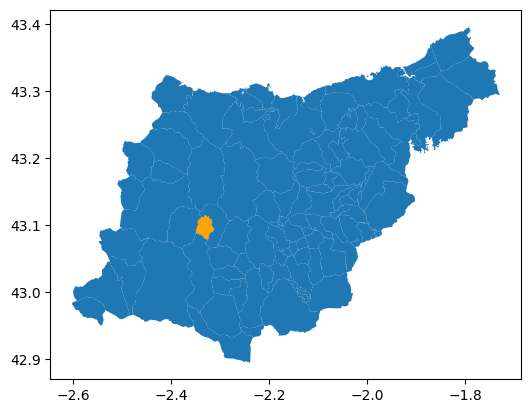

In [5]:
fig, ax = plt.subplots()
municipalities.plot(ax=ax)
area.plot(ax=ax, color="orange")
plt.show()

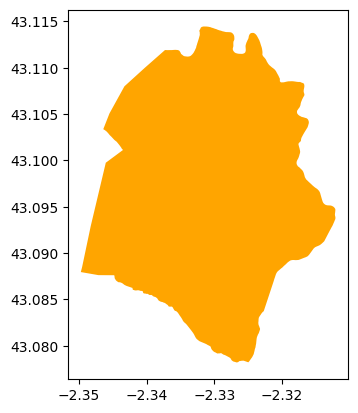

In [6]:
area.plot(color="orange")
plt.show()

I will calculate the total bounds of the catchment and create an Earth Engine rectangular geometry that will be used to filter satellite imagery later.

In [7]:
area_bounds = area.union_all().bounds
area_bounds

(-2.349746183316688,
 43.078202771749226,
 -2.312124248039057,
 43.114457232209624)

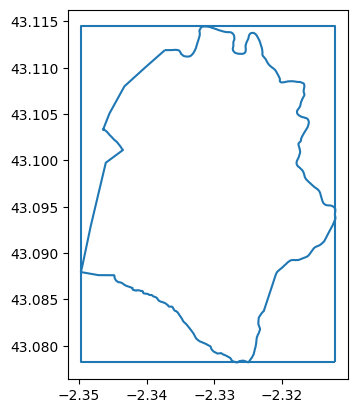

In [8]:
# Create a rectangular polygon (box) from the total bounds
bounds_box = box(area_bounds[0], area_bounds[1], area_bounds[2], area_bounds[3])

# Create corresponding rectangular geodataframe
area_box = gpd.GeoDataFrame(geometry=[bounds_box], crs=area.crs)

fig, ax = plt.subplots()
area.boundary.plot(ax=ax)
area_box.boundary.plot(ax=ax)
plt.show()

In [9]:
# Create an Earth Engine rectangular ROI: Region Of Interest
roi = ee.Geometry.Rectangle(
    [area_bounds[0], area_bounds[1], area_bounds[2], area_bounds[3]]
)

To later overlay the boundary on the map, the GeoDataFrame is converted into a GeoJSON dictionary.

In [10]:
# From GeoDataFrame to GeoJSON
area_geojson = json.loads(area[["MUNICIPIO", "geometry"]].to_json())

## CORINE Land Cover of the Study Area
In [CORINE Land Cover 2018](https://land.copernicus.eu/en/products/corine-land-cover/clc2018), in "Download **by area**", a map opens up with tools to select an area of interest. Here, [NUTS](https://land.copernicus.eu/en/faq/map-viewer/what-are-nuts) can be selected: `ES212` is the code of the small region I am interested in: the province in Spain called Gipuzkoa. I download the dataset for this area, selecting VECTOR type, GeoJSON file, and EPSG:4326 projection.

In [11]:
CLC2018_gipuzkoa = gpd.read_file("data/U2018_CLC2018_V2020_20u1.json")
CLC2018_gipuzkoa

,OBJECTID,Code_18,Remark,Area_Ha,ID,Shape_Length,Shape_Area,geometry
0,263931,231,None,36.420118,EU_263931,4.692983e+03,3.642012e+05,"POLYGON ((-2.22458 42.94839, -2.22646 42.94782..."
1,263936,231,None,28.578371,EU_263936,4.283677e+03,2.857837e+05,"POLYGON ((-2.29304 42.95019, -2.29319 42.9501,..."
2,263937,231,None,33.558522,EU_263937,4.286455e+03,3.355852e+05,"POLYGON ((-2.27937 42.94525, -2.27909 42.94516..."
3,265234,243,None,32.299053,EU_265234,5.481768e+03,3.229905e+05,"POLYGON ((-2.15456 42.96098, -2.15468 42.96095..."
4,265549,311,None,70.884837,EU_265549,6.552078e+03,7.088484e+05,"POLYGON ((-2.23704 42.91777, -2.23745 42.9196,..."
...,...,...,...,...,...,...,...,...
1535,2362369,324,None,46.427953,EU_2362369,7.939728e+03,4.642795e+05,"POLYGON ((-2.08388 42.99206, -2.08402 42.99209..."
1536,2362386,333,None,25.028593,EU_2362386,5.212849e+03,2.502859e+05,"POLYGON ((-2.34509 42.95487, -2.34557 42.95519..."
1537,2362387,333,None,66.010413,EU_2362387,7.389770e+03,6.601041e+05,"POLYGON ((-2.15638 42.97688, -2.15639 42.97689..."
1538,2362389,333,None,81.633259,EU_2362389,1.035282e+04,8.163326e+05,"POLYGON ((-2.32427 42.95627, -2.32428 42.95634..."


In the downloded package, a file with information about the labels is included.

In [12]:
labels = pd.read_excel(
    "data/clc_legend.xls", usecols=["CLC_CODE", "LABEL1", "LABEL2", "LABEL3"]
)
labels

,CLC_CODE,LABEL1,LABEL2,LABEL3
0,111,Artificial surfaces,Urban fabric,Continuous urban fabric
1,112,Artificial surfaces,Urban fabric,Discontinuous urban fabric
2,121,Artificial surfaces,"Industrial, commercial and transport units",Industrial or commercial units
3,122,Artificial surfaces,"Industrial, commercial and transport units",Road and rail networks and associated land
4,123,Artificial surfaces,"Industrial, commercial and transport units",Port areas
5,124,Artificial surfaces,"Industrial, commercial and transport units",Airports
6,131,Artificial surfaces,"Mine, dump and construction sites",Mineral extraction sites
7,132,Artificial surfaces,"Mine, dump and construction sites",Dump sites
8,133,Artificial surfaces,"Mine, dump and construction sites",Construction sites
9,141,Artificial surfaces,"Artificial, non-agricultural vegetated areas",Green urban areas


I will prepare lookup dictionaries to easily translate later between code numbers and label strings.

In [13]:
# LABEL1
code_label1 = {}
for i in range(1, 100):
    try:
        code_label1[i] = labels.loc[labels["CLC_CODE"] // 100 == i, "LABEL1"].unique()[0]
    except:
        pass

label1_code = {v: k for k, v in code_label1.items()}

# LABEL2
code_label2 = {}
for i in range(1, 100):
    try:
        code_label2[i] = labels.loc[labels["CLC_CODE"] // 10 == i, "LABEL2"].unique()[0]
    except:
        pass

label2_code = {v: k for k, v in code_label2.items()}

# LABEL3
code_label3 = {}
for i in range(1, 1000):
    try:
        code_label3[i] = labels.loc[labels["CLC_CODE"] == i, "LABEL3"].unique()[0]
    except:
        pass

label3_code = {v: k for k, v in code_label3.items()}

We can merge both dataframes on the label code.

In [14]:
# Convert the code column from object to numeric type before merge
CLC2018_gipuzkoa["Code_18"] = CLC2018_gipuzkoa["Code_18"].astype("int64")

# Merge both dataframes
CLC2018_gipuzkoa_labelled = pd.merge(
    CLC2018_gipuzkoa, labels, how="left", left_on="Code_18", right_on="CLC_CODE"
)

# Select and rearrange columns of interest
CLC2018_gipuzkoa_labelled = CLC2018_gipuzkoa_labelled.loc[
    :, ["CLC_CODE", "LABEL1", "LABEL2", "LABEL3", "Area_Ha", "geometry"]
]
CLC2018_gipuzkoa_labelled

,CLC_CODE,LABEL1,LABEL2,LABEL3,Area_Ha,geometry
0,231,Agricultural areas,Pastures,Pastures,36.420118,"POLYGON ((-2.22458 42.94839, -2.22646 42.94782..."
1,231,Agricultural areas,Pastures,Pastures,28.578371,"POLYGON ((-2.29304 42.95019, -2.29319 42.9501,..."
2,231,Agricultural areas,Pastures,Pastures,33.558522,"POLYGON ((-2.27937 42.94525, -2.27909 42.94516..."
3,243,Agricultural areas,Heterogeneous agricultural areas,"Land principally occupied by agriculture, with...",32.299053,"POLYGON ((-2.15456 42.96098, -2.15468 42.96095..."
4,311,Forest and semi natural areas,Forests,Broad-leaved forest,70.884837,"POLYGON ((-2.23704 42.91777, -2.23745 42.9196,..."
...,...,...,...,...,...,...
1535,324,Forest and semi natural areas,Scrub and/or herbaceous vegetation associations,Transitional woodland-shrub,46.427953,"POLYGON ((-2.08388 42.99206, -2.08402 42.99209..."
1536,333,Forest and semi natural areas,Open spaces with little or no vegetation,Sparsely vegetated areas,25.028593,"POLYGON ((-2.34509 42.95487, -2.34557 42.95519..."
1537,333,Forest and semi natural areas,Open spaces with little or no vegetation,Sparsely vegetated areas,66.010413,"POLYGON ((-2.15638 42.97688, -2.15639 42.97689..."
1538,333,Forest and semi natural areas,Open spaces with little or no vegetation,Sparsely vegetated areas,81.633259,"POLYGON ((-2.32427 42.95627, -2.32428 42.95634..."


Now we can clip our area of interest.

In [15]:
CLC_area = CLC2018_gipuzkoa_labelled.clip(area_box)

# Select relevant columns
CLC_area = CLC_area.loc[
    :, ["CLC_CODE", "LABEL1", "LABEL2", "LABEL3", "Area_Ha", "geometry"]
]
CLC_area

,CLC_CODE,LABEL1,LABEL2,LABEL3,Area_Ha,geometry
112,121,Artificial surfaces,"Industrial, commercial and transport units",Industrial or commercial units,208.723071,"POLYGON ((-2.32735 43.07823, -2.32736 43.07826..."
171,122,Artificial surfaces,"Industrial, commercial and transport units",Road and rail networks and associated land,121.691580,"POLYGON ((-2.31239 43.08254, -2.31247 43.08281..."
286,231,Agricultural areas,Pastures,Pastures,52.213839,"POLYGON ((-2.34973 43.07897, -2.34969 43.07897..."
172,122,Artificial surfaces,"Industrial, commercial and transport units",Road and rail networks and associated land,43.676461,"POLYGON ((-2.33191 43.07883, -2.33324 43.07996..."
74,112,Artificial surfaces,Urban fabric,Discontinuous urban fabric,39.004217,"POLYGON ((-2.31214 43.08313, -2.31216 43.08312..."
593,311,Forest and semi natural areas,Forests,Broad-leaved forest,25.225342,"POLYGON ((-2.34973 43.08633, -2.34966 43.08626..."
839,312,Forest and semi natural areas,Forests,Coniferous forest,65.437249,"POLYGON ((-2.32255 43.08993, -2.32262 43.08995..."
1075,313,Forest and semi natural areas,Forests,Mixed forest,176.826025,"POLYGON ((-2.34974 43.09774, -2.34963 43.09771..."
295,231,Agricultural areas,Pastures,Pastures,131.032916,"POLYGON ((-2.32279 43.09363, -2.32273 43.09358..."
43,111,Artificial surfaces,Urban fabric,Continuous urban fabric,95.744313,"POLYGON ((-2.31213 43.08702, -2.31219 43.0869,..."


And plot the results for the different label levels.

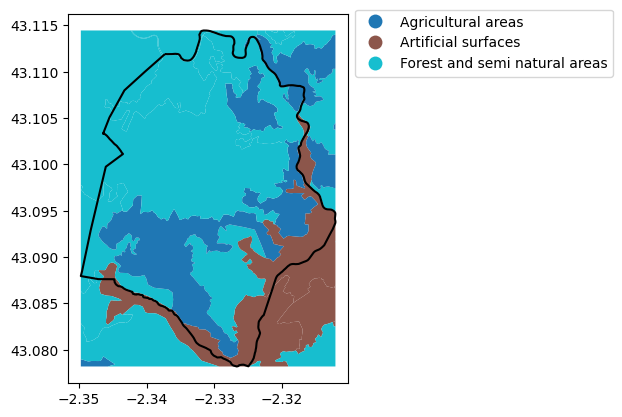

In [16]:
fig, ax = plt.subplots()
area.boundary.plot(ax=ax, color="black")
legend_kwds = {"loc": "upper left", "bbox_to_anchor": (1, 1.03)}
CLC_area.plot(ax=ax, column="LABEL1", legend=True, legend_kwds=legend_kwds)
plt.show()

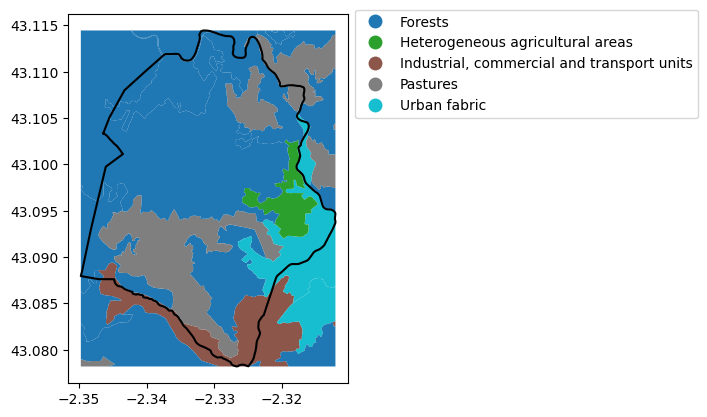

In [17]:
fig, ax = plt.subplots()
area.boundary.plot(ax=ax, color="black")
legend_kwds = {"loc": "upper left", "bbox_to_anchor": (1, 1.03)}
CLC_area.plot(ax=ax, column="LABEL2", legend=True, legend_kwds=legend_kwds)
plt.show()

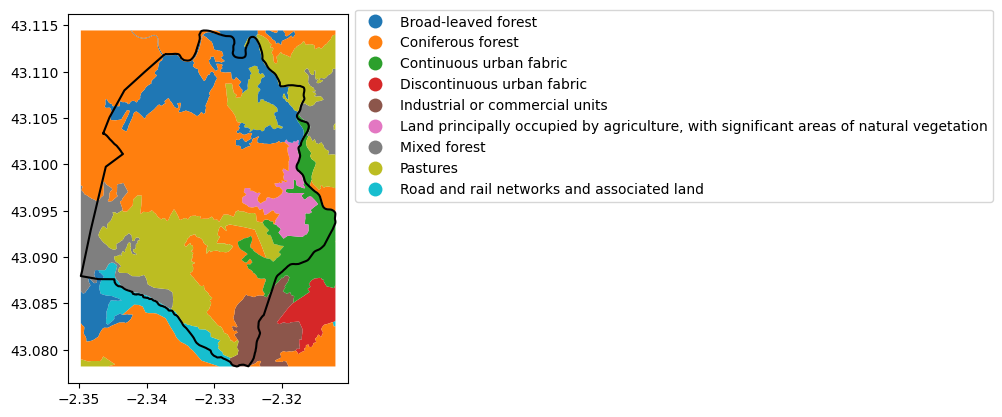

In [18]:
fig, ax = plt.subplots()
area.boundary.plot(ax=ax, color="black")
legend_kwds = {"loc": "upper left", "bbox_to_anchor": (1, 1.03)}
CLC_area.plot(ax=ax, column="LABEL3", legend=True, legend_kwds=legend_kwds)
plt.show()

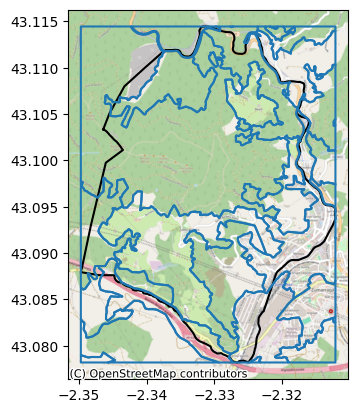

In [19]:
fig, ax = plt.subplots()
area.boundary.plot(ax=ax, color="black")
CLC_area.boundary.plot(ax=ax)
ctx.add_basemap(ax, crs=CLC_area.crs, source="OpenStreetMap.Mapnik")
plt.show()

According to the context map and my personal knowledge of the area, these classification of land provided by CORINE Land Cover 2018 seems to be correct.

## Satellite Imagery: Cloud and Shadow Masking
We will proceed now with the workflow for processing satellite imagery.

The following function masks clouds and their shadows from Sentinel-2 images by using:
1. The `QA60` band to mask clouds and cirrus clouds through bitwise operations.
2. The `SCL` band (Scene Classification Layer) to mask out shadow pixels and additional cloud artifacts.
3. After creating individual masks, they are combined.
4. Then, a smoothing process using dilation (`focal_max`) followed by erosion (`focal_min`) is applied to soften the mask’s edges.
5. Finally, the image is masked and normalized (dividing the reflectance values by 10,000).

In [20]:
def mask_s2_clouds_and_shadows(image):
    """Mask clouds and shadows from a Sentinel-2 image and soften edges."""
    qa = image.select("QA60")  # Select cloud mask
    cloud_bit_mask = 1 << 10  # Bit 10: clouds
    cirrus_bit_mask = 1 << 11  # Bit 11: cirrus
    cloud_mask = (
        qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    )

    scl = image.select("SCL")  # Select shadows mask
    shadow_mask = scl.neq(3)  # Pixels that are not cloud shadows
    cloud_class_mask = scl.neq(9)  # Pixels that are not clouds

    # Combine both masks
    final_mask = cloud_mask.And(shadow_mask).And(cloud_class_mask)

    # Softening of mask edges using dilation and erosion
    dilated_mask = final_mask.focal_max(
        radius=50, units="meters"
    )  # Dilation (expands the mask)
    smoothed_mask = dilated_mask.focal_min(
        radius=50, units="meters"
    )  # Erosion (reduces the mask)

    # Mask the image and normalize
    return image.updateMask(smoothed_mask).divide(10000)

The following helper function calls the previous cloud/shadow masking function and then selects only the relevant bands for visualization (B4, B3, B2 corresponding to red, green, and blue).

In [21]:
def prepare_image(image):
    """Call cloud and shadows masking function and select relevant bands for visualization."""
    bands = ["B4", "B3", "B2"]  # RGB bands
    return mask_s2_clouds_and_shadows(image).select(bands)

## Creating Composited Images for Different Years
For each time period the following steps are taken:

1. Filtering the Sentinel-2 Collection: images from the “COPERNICUS/S2_SR_HARMONIZED” collection are filtered by date range, cloud coverage (only images with less than 20% cloud cover) and intersection with the ROI.
2. Applying Preprocessing: The `prepare_image` function is mapped over the image collection to remove clouds/shadows and select the RGB bands.
3. Creating a Mosaic: the collection is reduced with a minimum reducer (`ee.Reducer.min()`) to create a single clean mosaic for that period. This effectively creates a composite image that picks the lowest reflectance value for each pixel (which is common for reducing cloud effects).

A visualization dictionary is defined for rendering the RGB composites with set minimum and maximum values. These mosaics are then added as separate layers on an interactive geemap instance, which allows the user to visually compare the images from different years over the catchment area.

In [22]:
image_collection = "COPERNICUS/S2_SR_HARMONIZED"
cloudy_pixel_percentage = 20  # Less than 20% cloudy pixels

periods = [
    ("2018-01-01", "2018-12-31"),
    ("2024-01-01", "2024-12-31"),
]

clean_images = []

for period in periods:
    # Get dataset
    dataset = (
        ee.ImageCollection(image_collection)
        .filterDate(period[0], period[1])
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloudy_pixel_percentage))
        .filterBounds(roi)  # Region Of Interest
        .map(prepare_image)  # Apply masks, select bands
    )

    # Composite image: create a single clean mosaic
    clean_images.append(dataset.reduce(ee.Reducer.min()))

In [23]:
# Create map
m = geemap.Map()

# Center the map in the area
m.set_center(
    (area_bounds[0] + area_bounds[2]) / 2,  # lon
    (area_bounds[1] + area_bounds[3]) / 2,  # lat
    14,
)  # The zoom level, from 0 to 24

# Visualization configuration
visualization = {
    "min": 0.0,
    "max": 0.3,
    "bands": ["B4_min", "B3_min", "B2_min"],
}

# Add to the map clean image mosaics
for clean_image, period in zip(clean_images, periods):
    m.add_layer(clean_image.clip(roi), visualization, name=period[0] + "/" + period[1])

# Add boundary of the area
m.add_geojson(
    area_geojson,
    layer_name="Area",
    style={"color": "red", "weight": 2, "fillColor": "#FFFFFF00", "fillOpacity": 0},
)

# Show map
m

Map(center=[43.096330001979425, -2.3309352156778727], controls=(WidgetControl(options=['position', 'transparen…

## Preparing Land Cover Samples and Training the model
`LABEL1` type Land Cover Samples for the area of interest will be converted into GEE feature collections.

In [24]:
# Generate GeoJSON for each land type (each class)
gjsons, classes = [], []
for label in code_label1.values():
    if CLC_area["LABEL1"].str.contains(label).any():
        gdf = CLC_area.loc[
            CLC_area["LABEL1"] == label, ["geometry"]
        ]  # Include geometry
        gdf["class"] = label1_code[label]  # Add class property
        geojson = json.loads(gdf.to_json())
        gjsons.append(geojson)
        classes.append(label1_code[label])

# Generate GEE feature collections
featurecollections = []
for gjson in gjsons:  # For each label class
    features = []
    for feature in gjson["features"]:  # For each geometry in that particular class
        features.append(
            ee.Feature(
                ee.Geometry.Polygon(feature["geometry"]["coordinates"][0]),
                {"class": feature["properties"]["class"]},
            )
        )
    featurecollections.append(ee.FeatureCollection(features))

# Combined feature collections
featurecollections_samples = ee.FeatureCollection(featurecollections).flatten()

These features collections will be served as sample regions to a model to be trained on the image from 2018.

In [25]:
clean_image_2018 = clean_images[0]  # Image of 2018

training_data = clean_image_2018.sampleRegions(
    collection=featurecollections_samples,  # Training dataset
    properties=["class"],  # Class property
    scale=30,  # Spatial resolution in meters
)

n_trees = 50
classifier = ee.Classifier.smileRandomForest(n_trees).train(
    features=training_data,
    classProperty="class",  # The class of interest to predict
    inputProperties=clean_image.bandNames(),  # Bands used as input
)

We can now call the model to add land type classification band on the images.

In [26]:
clean_image_2024 = clean_images[1]  # Image of 2024
classified_image_2024 = clean_image_2024.classify(classifier)

# We can also apply the classifier to the image used in training
classified_image_2018 = clean_image_2018.classify(classifier)

And show results in a map.

In [27]:
# Create map
Map = geemap.Map()
Map.centerObject(roi, 14)

visparams = {
    "min": min(classes),
    "max": max(classes),
    "palette": list(mcolors.TABLEAU_COLORS.values())[: len(classes)],
}

Map.add_layer(clean_image_2018.clip(roi), visualization, "Image 2018")
Map.add_layer(classified_image_2018.clip(roi), visparams, "Land Cover 2018")
Map.add_layer(classified_image_2024.clip(roi), visparams, "Land Cover 2024")

Map.add_geojson(
    area_geojson,
    layer_name="Area",
    style={"color": "black", "weight": 2, "fillColor": "#FFFFFF00", "fillOpacity": 0},
)

# Show map
Map

Map(center=[43.096329753842426, -2.3309352156735748], controls=(WidgetControl(options=['position', 'transparen…

## Export classified map (GeoJSON)
- First, the classification image needs to be vectorized according to the band called `classification`, which holds the class numbers.
- Then the file is exported to Google Drive in GeoJSON format.

In [28]:
classified_images = [
    (classified_image_2018, "classified_image_2018"),
    (classified_image_2024, "classified_image_2024"),
]


def export_geojson(classified_image, filename):
    # Vectorize classification image
    vectors = classified_image.select("classification").reduceToVectors(
        geometry=roi,
        scale=10,  # Sentinel-2 image resolution: 10 m/px
        geometryType="polygon",  # "centroid" if you want points instead
        eightConnected=False,
        labelProperty="class",  # the attribute name on each feature
        reducer=ee.Reducer.countEvery(),
    )
    # Export to Google Drive
    task = ee.batch.Export.table.toDrive(
        **{
            "collection": vectors,
            "description": "classified_image_export",
            # "folder": "geojson",
            "fileNamePrefix": filename,
            "fileFormat": "GeoJSON",
        }
    )
    task.start()
    return task


for classified_image, name in classified_images:
    export_geojson(classified_image, name)

## Analyzing Results
Exported GeoJSON files will be converted into GeoDataframes to perform analysis.

In [30]:
classified_2024 = gpd.read_file("classified_image_2024.geojson")[["class", "geometry"]]
classified_2024["label"] = classified_2024["class"].apply(lambda x: code_label1[x])
classified_2024 = classified_2024.clip(area)
classified_2024

,class,geometry,label
3695,3,"MULTIPOLYGON (((-2.33014 43.07943, -2.33014 43...",Forest and semi natural areas
3728,3,"POLYGON ((-2.33059 43.07997, -2.33041 43.07997...",Forest and semi natural areas
3761,2,"POLYGON ((-2.33059 43.07997, -2.33059 43.07993...",Agricultural areas
3923,2,"POLYGON ((-2.33194 43.08042, -2.33185 43.08042...",Agricultural areas
3843,3,"POLYGON ((-2.33122 43.08033, -2.33131 43.08033...",Forest and semi natural areas
...,...,...,...
3400,1,"POLYGON ((-2.32861 43.1132, -2.32852 43.1132, ...",Artificial surfaces
3205,2,"POLYGON ((-2.32762 43.11347, -2.32753 43.11347...",Agricultural areas
3144,1,"POLYGON ((-2.32727 43.11365, -2.32727 43.11356...",Artificial surfaces
3145,2,"POLYGON ((-2.32745 43.11374, -2.32745 43.11378...",Agricultural areas


In [31]:
classified_2018 = gpd.read_file("classified_image_2018.geojson")[["class", "geometry"]]
classified_2018["label"] = classified_2018["class"].apply(lambda x: code_label1[x])
classified_2018 = classified_2018.clip(area)
classified_2018

,class,geometry,label
4626,2,"POLYGON ((-2.33589 43.08419, -2.33571 43.08419...",Agricultural areas
4663,2,"POLYGON ((-2.33598 43.08428, -2.33589 43.08428...",Agricultural areas
4675,1,"POLYGON ((-2.33625 43.08428, -2.33634 43.08428...",Artificial surfaces
4627,2,"POLYGON ((-2.33589 43.08446, -2.33571 43.08446...",Agricultural areas
4699,2,"POLYGON ((-2.33625 43.08473, -2.33607 43.08473...",Agricultural areas
...,...,...,...
2010,2,"MULTIPOLYGON (((-2.32268 43.11114, -2.32268 43...",Agricultural areas
2317,2,"POLYGON ((-2.32322 43.11177, -2.32313 43.11177...",Agricultural areas
2252,3,"POLYGON ((-2.32304 43.11186, -2.32304 43.11195...",Forest and semi natural areas
2318,2,"POLYGON ((-2.32313 43.1124, -2.32322 43.1124, ...",Agricultural areas


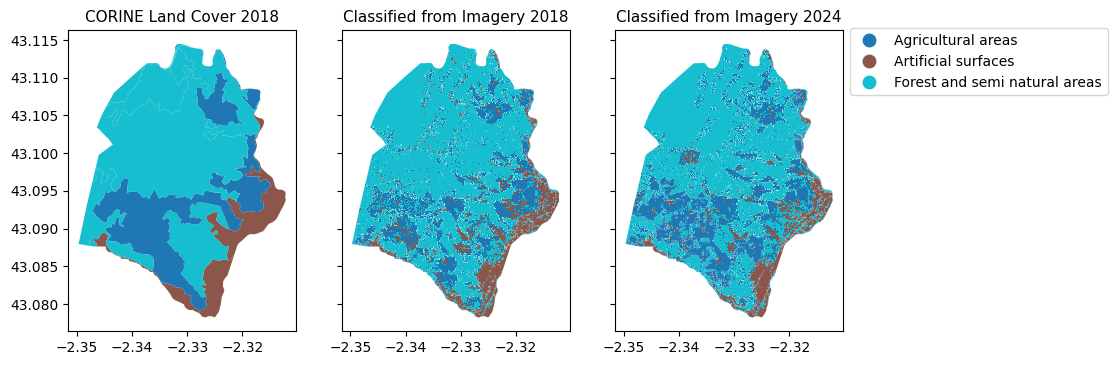

In [34]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(10, 6))
legend_kwds = {"loc": "upper left", "bbox_to_anchor": (1, 1.03)}
CLC_area.clip(area).plot(ax=ax[0], column="LABEL1")
classified_2018.plot(ax=ax[1], column="label")
classified_2024.plot(ax=ax[2], column="label", legend=True, legend_kwds=legend_kwds)
ax[0].set_title("CORINE Land Cover 2018", fontsize=11)
ax[1].set_title("Classified from Imagery 2018", fontsize=11)
ax[2].set_title("Classified from Imagery 2024", fontsize=11)
plt.show()

For example, we could calculate how forests have changed in this period. My impression was that tree covered land had receded.

In [36]:
forests_2018_ha = (
    classified_2018[classified_2018["label"] == "Forest and semi natural areas"]
    .to_crs(3857)
    .union_all()
    .area
    / 10000
)
print(f"Forests in 2018 -> {forests_2018_ha:.0f} hectares")

Forests in 2018 -> 972 hectares


In [39]:
forests_2024_ha = (
    classified_2024[classified_2024["label"] == "Forest and semi natural areas"]
    .to_crs(3857)
    .union_all()
    .area
    / 10000
)
print(f"Forests in 2024 -> {forests_2024_ha:.0f} hectares")

Forests in 2024 -> 899 hectares


So indeed, forests seem to be declining.

In [38]:
print(f"Forest area change -> {(forests_2024_ha - forests_2018_ha):.0f} hectares")

Forest area change -> -74 hectares
